In [31]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, beta
from IPython.display import Image
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv('ab_data.csv')

In [33]:
df.sample(5)

,user_id,timestamp,group,landing_page,converted
288391,731650,2017-01-18 18:05:06.681921,treatment,new_page,0
155044,662349,2017-01-04 13:41:51.801132,control,old_page,0
134546,847455,2017-01-24 13:30:11.692593,control,old_page,0
141663,668078,2017-01-15 02:05:39.001066,control,old_page,1
79972,779292,2017-01-15 20:41:32.513679,treatment,new_page,0


In [34]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")
print(f"Percentage of users in control: {round(df[df['group']=='control'].shape[0] * 100 / df.shape[0])}%")

Number of unique users in experiment: 290584
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']
Percentage of users in control: 50%


###  Data Processing

In [35]:
sample = df[df['user_id'].isin([746755,722274])]
sample

,user_id,timestamp,group,landing_page,converted
29073,746755,2017-01-11 01:28:57.083669,control,new_page,1
105487,722274,2017-01-19 01:46:53.093257,control,old_page,0
262554,722274,2017-01-09 21:21:23.638444,control,new_page,0
286566,746755,2017-01-05 03:40:08.457451,control,old_page,0


Get First timestamp for each username. In this dataset, it is the timestamp of first conversion, but in reality, make sure to do one of the following:
1. Get timestamp of first exposure
2. Remove users with multiple buckets

In [36]:
# 1. Get timestamp of first exposure
first_conversion = sample.groupby('user_id')['timestamp'].min().to_frame().reset_index()
sample = sample.merge(first_conversion, on=['user_id', 'timestamp'])
sample

,user_id,timestamp,group,landing_page,converted
0,722274,2017-01-09 21:21:23.638444,control,new_page,0
1,746755,2017-01-05 03:40:08.457451,control,old_page,0


In [37]:
counter = df['user_id'].value_counts()
(counter > 1).value_counts()

False    286690
True       3894
Name: user_id, dtype: int64

3894 (1.34\%) user_ids have been exposed to the old AND new page. It should be okay to remove them

In [38]:
#2. Remove users with multiple buckets
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df = df.merge(valid_users, on=['user_id'])

In [39]:
# Add week column to see the data as you would during experiment
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])
df.sample()

,user_id,timestamp,group,landing_page,converted,week
236810,675706,2017-01-22 12:56:36.330894,treatment,new_page,1,3


<AxesSubplot:>

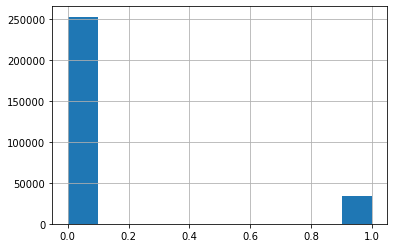

In [40]:
df['converted'].hist()

In [41]:
df["timestamp"]=df["timestamp"].astype("datetime64")
pd.DatetimeIndex(df["timestamp"]).date
df = df.set_index("timestamp")

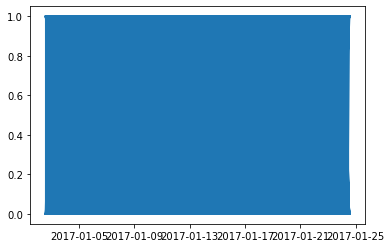

In [45]:
plt.plot(df["converted"])

In [10]:
df['week'].value_counts()

2    91380
3    91056
1    83745
4    20509
Name: week, dtype: int64

### 4. Experiment: Frequentist Approach

In [11]:
# Get Stats
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = df[df['week'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round(treatment_conversion_perc - control_conversion_perc, 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.873%
Control Conversion Rate: 12.017%
Lift = -0.144%


#### Chi-Squared Test (Test of independence)

$$
H_0: \text{Control & Treatment are independent} \\
H_A: \text{Control & Treatment are not independent} 
$$

In [12]:
# Create Contingency Table for Chi Squared Test
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted
contingency_table = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])

In [13]:
contingency_table

array([[ 17220, 126073],
       [ 17025, 126372]], dtype=int64)

In [14]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)

In [241]:
chi, p_value

(1.1276469852100297, 0.28827779822703054)

Since the p_value > 0.05, we cannot reject null hypothesis. But, we cannot conclude if there exists a relationship between the control and treatment groups.

28.83% probability that a more extreme chi quare than 1.128 can occured by chance

# Difference Between Bayesian and Frequentist Approach(PPT)

### 5. Experiment: Bayesian Approach

Input the _prior distribution_           
Taking the prior beta distribtion from the first week 

In [15]:
prior = df[(df['week'] == 1) & (df['group']=='control')]

In [16]:
prior_means = []
for i in range(10000):
    prior_means.append(prior.sample(1000)['converted'].mean())

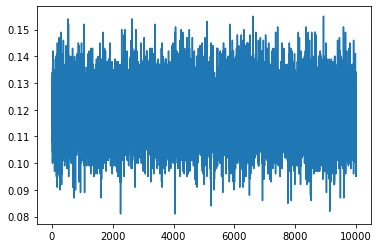

In [46]:
plt.plot(prior_means)

In [17]:
prior_means[:10]

[0.111, 0.127, 0.11, 0.118, 0.131, 0.119, 0.112, 0.116, 0.129, 0.132]

In [49]:
# Model Beta Distribtion 
prior_alpha, prior_beta, _, _ = beta.fit(prior_means, floc=0, fscale=1)
print(prior_alpha,prior_beta)

121.2789329488911 895.8215234429508


In [19]:
# Get Stats
NUM_WEEKS = 4 
experiment_data = df[(df['week'] > 1) & (df['week'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round((treatment_conversion_perc - control_conversion_perc) / control_conversion_perc , 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.909%
Control Conversion Rate: 12.058%
Lift = -0.012%


In [20]:
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted

# Update Prior 
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)


control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")

Probability that treatment > control: 15.9%


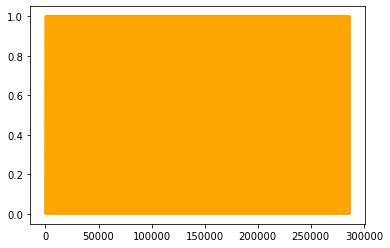

In [62]:
plt.plot(control['converted'],"orange")

In [21]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.12056333968542098, Variance: 1.033610030966899e-06
Treatment Posterior: Mean: 0.11909440399565213, Variance: 1.0245097607837674e-06


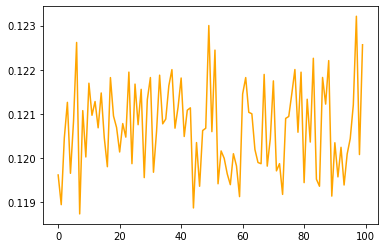

In [64]:
plt.plot(posterior_control.rvs(100),"orange")

We can even make statements like the following which are actionable:

In [22]:
lift_percentage = (treatment_samples - control_samples) / control_samples
print(f"Probability that we observe a 2% lift: {np.mean((100 * lift_percentage) > 2) * 100}%")

Probability that we observe a 2% lift: 0.4%
